# Practical 3: MNIST

This is the first task of Practical 3. Your task is to build a (convolutional) neural network to classify the handwritten digits from the MNIST dataset (http://yann.lecun.com/exdb/mnist/). 

You should get an accuracy of **at least 97%** to pass the practical. 

The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-MNIST.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-MNIST.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.9.2'

In [3]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as normalisation. 

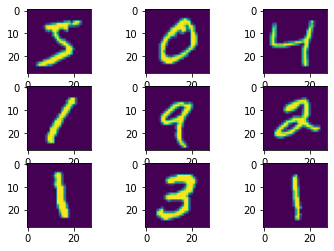

(28, 28)
(28, 28, 1)


In [4]:
from keras.datasets import mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

print(X_train_full.shape[1:])

# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# normalisation
X_train_full = X_train_full/255.0
X_test = X_test/255.0

# expand dim
X_train_full = np.expand_dims(X_train_full, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print(X_train_full.shape[1:])

# get validation dataset
np.random.seed(42) # set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
v_indx = int(X_train_full.shape[0] * 0.2)
##print(v_indx)
X_valid, X_train = X_train_full[shuffled_indices[:v_indx]], X_train_full[shuffled_indices[v_indx:]]
y_valid, y_train = y_train_full[shuffled_indices[:v_indx]], y_train_full[shuffled_indices[v_indx:]]

## Build and train the model

Build and train your model. 

In [5]:
# TODO: Build your model

##transfer the keras model to a scikit-learn regressor to choose hyperparameter
def build_model(n_conv=1, n_filter=4, kernel_size=2, n_hidden=1, n_neurons=30, learning_rate=0.001, input_shape=[28,28,1]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape)) ##input layer
    for layer in range(n_conv): ##conv layers
      model.add(keras.layers.Conv2D(filters=n_filter, kernel_size=kernel_size, activation="elu", kernel_initializer='he_normal', padding="same"))
    model.add(keras.layers.MaxPooling2D(pool_size=2)) ##pooling layer
    model.add(keras.layers.Flatten()) ##starting fully connected layers
    for layer in range(n_hidden):
      model.add(keras.layers.BatchNormalization())
      model.add(keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal")) ##add BN layers after all hidden layers' activation function
    model.add(keras.layers.Dense(10, activation="softmax")) ##output layer
    model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return model
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

##set hyperparameter distribution
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    "n_conv": [1, 2, 3, 4],
    "n_filter": [2, 3, 4, 5, 6],
    "kernel_size": [2, 3, 4, 5, 6],
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(50, 100).tolist(),
    "learning_rate": [1e-4, 1e-3, 1e-2],
}

##search for best hyperparamter
rnd_search_cv = RandomizedSearchCV(estimator=keras_reg, 
                  param_distributions=param_distributions, 
                  n_iter=1, 
                  cv=3)
rnd_search_cv.fit(X_train_full, y_train_full, epochs=1, validation_data=(X_valid, y_valid))

##build model
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
model = rnd_search_cv.best_estimator_.model

<ipython-input-5-f7112bc25df3>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


1875/1875 [==============================] - 9s 5ms/step - loss: 0.2725 - accuracy: 0.9159 - val_loss: 0.1391 - val_accuracy: 0.9578
{'n_neurons': 85, 'n_hidden': 1, 'n_filter': 2, 'n_conv': 4, 'learning_rate': 0.001, 'kernel_size': 2}
-0.20528851946194968


In [6]:
# show the structure of your model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 2)         10        
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 2)         18        
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 2)         18        
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 2)         18        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 2)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 392)               0         
                                                      

Epoch 1/10
480/480 [==============================] - 3s 6ms/step - loss: 0.1199 - accuracy: 0.9639 - val_loss: 0.1093 - val_accuracy: 0.9670
Epoch 2/10
480/480 [==============================] - 3s 5ms/step - loss: 0.1035 - accuracy: 0.9687 - val_loss: 0.1040 - val_accuracy: 0.9693
Epoch 3/10
480/480 [==============================] - 3s 5ms/step - loss: 0.0908 - accuracy: 0.9718 - val_loss: 0.0954 - val_accuracy: 0.9704
Epoch 4/10
480/480 [==============================] - 3s 5ms/step - loss: 0.0807 - accuracy: 0.9743 - val_loss: 0.0943 - val_accuracy: 0.9709
Epoch 5/10
480/480 [==============================] - 3s 5ms/step - loss: 0.0723 - accuracy: 0.9769 - val_loss: 0.0889 - val_accuracy: 0.9735
Epoch 6/10
480/480 [==============================] - 3s 5ms/step - loss: 0.0649 - accuracy: 0.9788 - val_loss: 0.0838 - val_accuracy: 0.9752
Epoch 7/10
480/480 [==============================] - 3s 5ms/step - loss: 0.0585 - accuracy: 0.9815 - val_loss: 0.0886 - val_accuracy: 0.9728
Epoch 

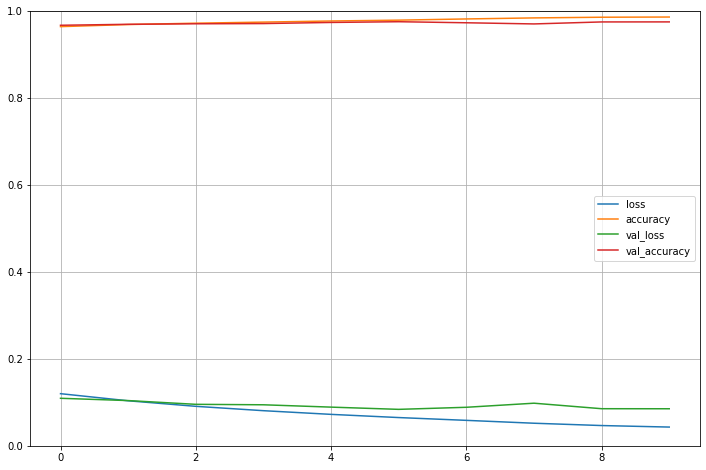

In [7]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
history = model.fit(X_train, y_train, batch_size=100, epochs=10, 
                    validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the seafile link we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [8]:
model.save('FDS22-M020-MNIST.h5') # change the file name according to your repository name

## Load the model and evaluate it on the test data

In [9]:
model = keras.models.load_model("FDS22-M020-MNIST.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0865 - accuracy: 0.9729


[0.08652522414922714, 0.9728999733924866]

## Short report



First, we preprocess the data with one-hot encoding, normalization and dimention expansion.

Then, we build the model in the following steps:

Create build_model function and transfer it to a scikit-learn regressor.

Random search is used to decide the number of convolution layers, filters, hidden layers and neurons, and learning rate. The initial parameter distributions were modified accordingly while the performance in some area is very good. Finally, we ended up with current distributions.

The ultimate model is built on the best parameters.